In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from lesson_functions import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle

# set the seed
np.random.seed(450)

def predict(features):
    features = np.array(features).astype(np.float64)
    features = scaler.transform([features])
    return clf.predict(features)

def score(features, labels):
    features = np.array(features).astype(np.float64)
    features = scaler.transform([features])
    return clf.score(features, labels)

def get_heatmap(img, hot_windows, heatmap_threshold=0, clip_range=(0,255)):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = np.clip(heatmap, clip_range[0], clip_range[1])
    heatmap = apply_threshold(heatmap, heatmap_threshold)
    return heatmap
    
def get_all_windows(xstart=0, xstop=1280, ystart = 400, ystop = 656):
    ydiff = ystop - ystart
    ystart_64 = ystart
    ystop_64 = ystop
    ystart_96 = ystart
    ystop_96 = ystop
    ystart_128 = ystart
    ystop_128 = ystop
    
    overlap_128 = (0.75, 0.75)
    overlap_96 = (0.75, 0.75)
    overlap_64 = (0.75, 0.75)

    window_list_128 = slide_window(x_start_stop=[xstart, xstop], y_start_stop=[ystart_128, ystop_128], 
                    xy_window=(128, 128), xy_overlap=overlap_128)
    window_list_96 = slide_window(x_start_stop=[xstart, xstop], y_start_stop=[ystart_96, ystop_96], 
                    xy_window=(96, 96), xy_overlap=overlap_96)
    window_list_64 = slide_window(x_start_stop=[xstart, xstop], y_start_stop=[ystart_64, ystop_64], 
                    xy_window=(64, 64), xy_overlap=overlap_64)
    return window_list_128, window_list_96, window_list_64

#### Visualize Sliding Windows

Total number of windows : 1536


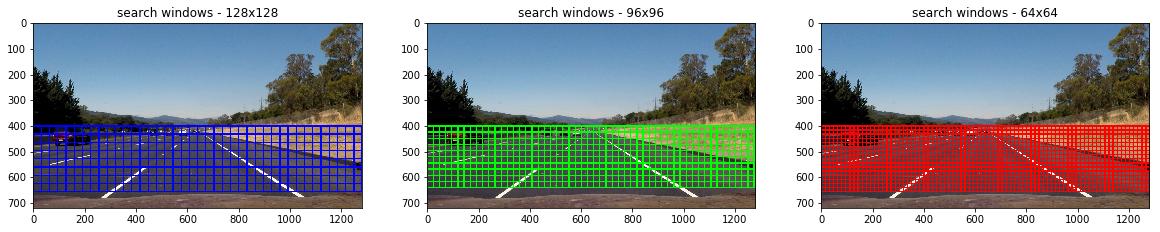

In [2]:
w_128, w_96, w_64 = get_all_windows()

out_img = mpimg.imread('./test_images/straight_lines2.jpg')
out_img1 = draw_boxes(out_img, w_128, color=(0, 0, 255), thick=4)
out_img2 = draw_boxes(out_img, w_96, color=(0, 255, 0), thick=4)
out_img3 = draw_boxes(out_img, w_64, color=(255, 0, 0), thick=4)

all_windows = w_128 + w_96 + w_64
print("Total number of windows : {}".format(len(all_windows)))

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
ax1.imshow(out_img1)
ax1.set_title('search windows - 128x128')
ax2.imshow(out_img2)
ax2.set_title('search windows - 96x96')
ax3.imshow(out_img3)
ax3.set_title('search windows - 64x64')
plt.show()

In [3]:
class VehicleDetection:
    def __init__(self, model_file='./model.pkl', heatmap_history_n_items=0, heatmap_threshold=0, debug=False):
        
        # load model and initialize
        model = joblib.load(model_file)
        self.clf = model["classifier"]
        self.scaler = model["scaler"]
        self.color_space = model['color_space']
        self.spatial_size = model['spatial_size']
        self.hist_bins = model['hist_bins']
        self.orient = model['orient']
        self.pix_per_cell = model['pix_per_cell']
        self.cell_per_block = model['cell_per_block']
        self.hog_channel = model['hog_channel']
        self.spatial_feat = model['spatial_feat']
        self.hist_feat = model['hist_feat']
        self.hog_feat = model['hog_feat']
        
        self.all_windows = None
 
        self.heatmap_history = []
        self.heatmap_history_n_items = heatmap_history_n_items
        self.heatmap_threshold = heatmap_threshold
        # for debug
        self.frame_number = 0
        self.debug = debug
        return
    
    def print_settings(self):
        print("Settings from model")
        print("=======================")
        print("Color space : {}".format(self.color_space))
        print("Spatial size : {}".format(self.spatial_size))
        print("Histogram bins : {}".format(self.hist_bins))
        print("Orientation : {}".format(self.orient))
        print("Pixel per cell : {}".format(self.pix_per_cell))
        print("Cell per block : {}".format(self.cell_per_block))
        print("HOG channel : {}".format(self.hog_channel))
        print("Spatial feature : {}".format(self.spatial_feat))
        print("Histogram feature : {}".format(self.hist_feat))
        print("HOG feature : {}".format(self.hog_feat))
    
    def get_hot_windows(self, image):
        # initialize once, if the image width/height are different
        if self.all_windows is None:
            w_32, w_64, w_96 = get_all_windows(xstart=0, xstop=image.shape[1], ystart=400, ystop=656)
            self.all_windows = w_32 + w_64 + w_96

        # get the hot windows for the given frame/image
        hot_windows = search_windows(image, self.all_windows, self.clf, self.scaler, 
                                     color_space=self.color_space, pix_per_cell=self.pix_per_cell, 
                                     hog_channel=self.hog_channel)
        return hot_windows
    
    def get_all_hot_windows(self, img):
        ystart = 400
        ystop = 656
        scale = 2.0
        hot_windows_128 = find_cars(img, ystart, ystop, scale, self.clf, self.scaler, self.orient, 
                                    self.pix_per_cell, self.cell_per_block, self.spatial_size, self.hist_bins)    
        scale = 1.5
        ystart = 400
        ystop = 656
        hot_windows_96 = find_cars(img, ystart, ystop, scale, self.clf, self.scaler, self.orient, 
                                    self.pix_per_cell, self.cell_per_block, self.spatial_size, self.hist_bins)    
        ystart = 400
        ystop = 656
        scale = 1.0
        hot_windows_64 = find_cars(img, ystart, ystop, scale, self.clf, self.scaler, self.orient, 
                                    self.pix_per_cell, self.cell_per_block, self.spatial_size, self.hist_bins)    
        #ystart = 400
        #ystop = 568
        #scale = 0.5
        #hot_windows_32 = find_cars(img, ystart, ystop, scale, self.clf, self.scaler, self.orient, 
        #                            self.pix_per_cell, self.cell_per_block, self.spatial_size, self.hist_bins)    
        #return hot_windows_32 + hot_windows_64 + hot_windows_96 + hot_windows_128
        return hot_windows_64 + hot_windows_96 + hot_windows_128

    def pipeline(self, image):
        
        #if self.debug == True:
        #    if self.frame_number < 700 or self.frame_number > 900:
        #        self.frame_number +=1
        #        return image
        
        # find hot windows
        #hot_windows = self.get_hot_windows(image)
        hot_windows = self.get_all_hot_windows(image)
        
        # generate heatmap, take an average over last 4 frames
        heatmap = get_heatmap(image, hot_windows)
        
        # take average of heatmap with previous 4 frames
        self.heatmap_history.append(heatmap)
        if self.heatmap_history_n_items > 0:
            self.heatmap_history = self.heatmap_history[-self.heatmap_history_n_items:]
        else:
            self.heatmap_history = self.heatmap_history[-1:]
            
        avg_heat = np.vstack(self.heatmap_history)/len(self.heatmap_history)
        if self.heatmap_threshold > 0:
            avg_heat = apply_threshold(avg_heat, threshold=self.heatmap_threshold)
            
        avg_heat = np.clip(avg_heat, 0, 255)
        labels = label(avg_heat)
        image = draw_labeled_bboxes(image, labels)
        
        if self.debug == True:
            if self.frame_number > 700 and self.frame_number < 900:
                mpimg.imsave("./output/frame_{}.jpg".format(self.frame_number),image)

        self.frame_number +=1
        return image

In [4]:
# print model settings
vehicle_detection = VehicleDetection()
vehicle_detection.print_settings()

Settings from model
Color space : YCrCb
Spatial size : (32, 32)
Histogram bins : 32
Orientation : 9
Pixel per cell : 8
Cell per block : 2
HOG channel : ALL
Spatial feature : True
Histogram feature : True
HOG feature : True


#### Test images

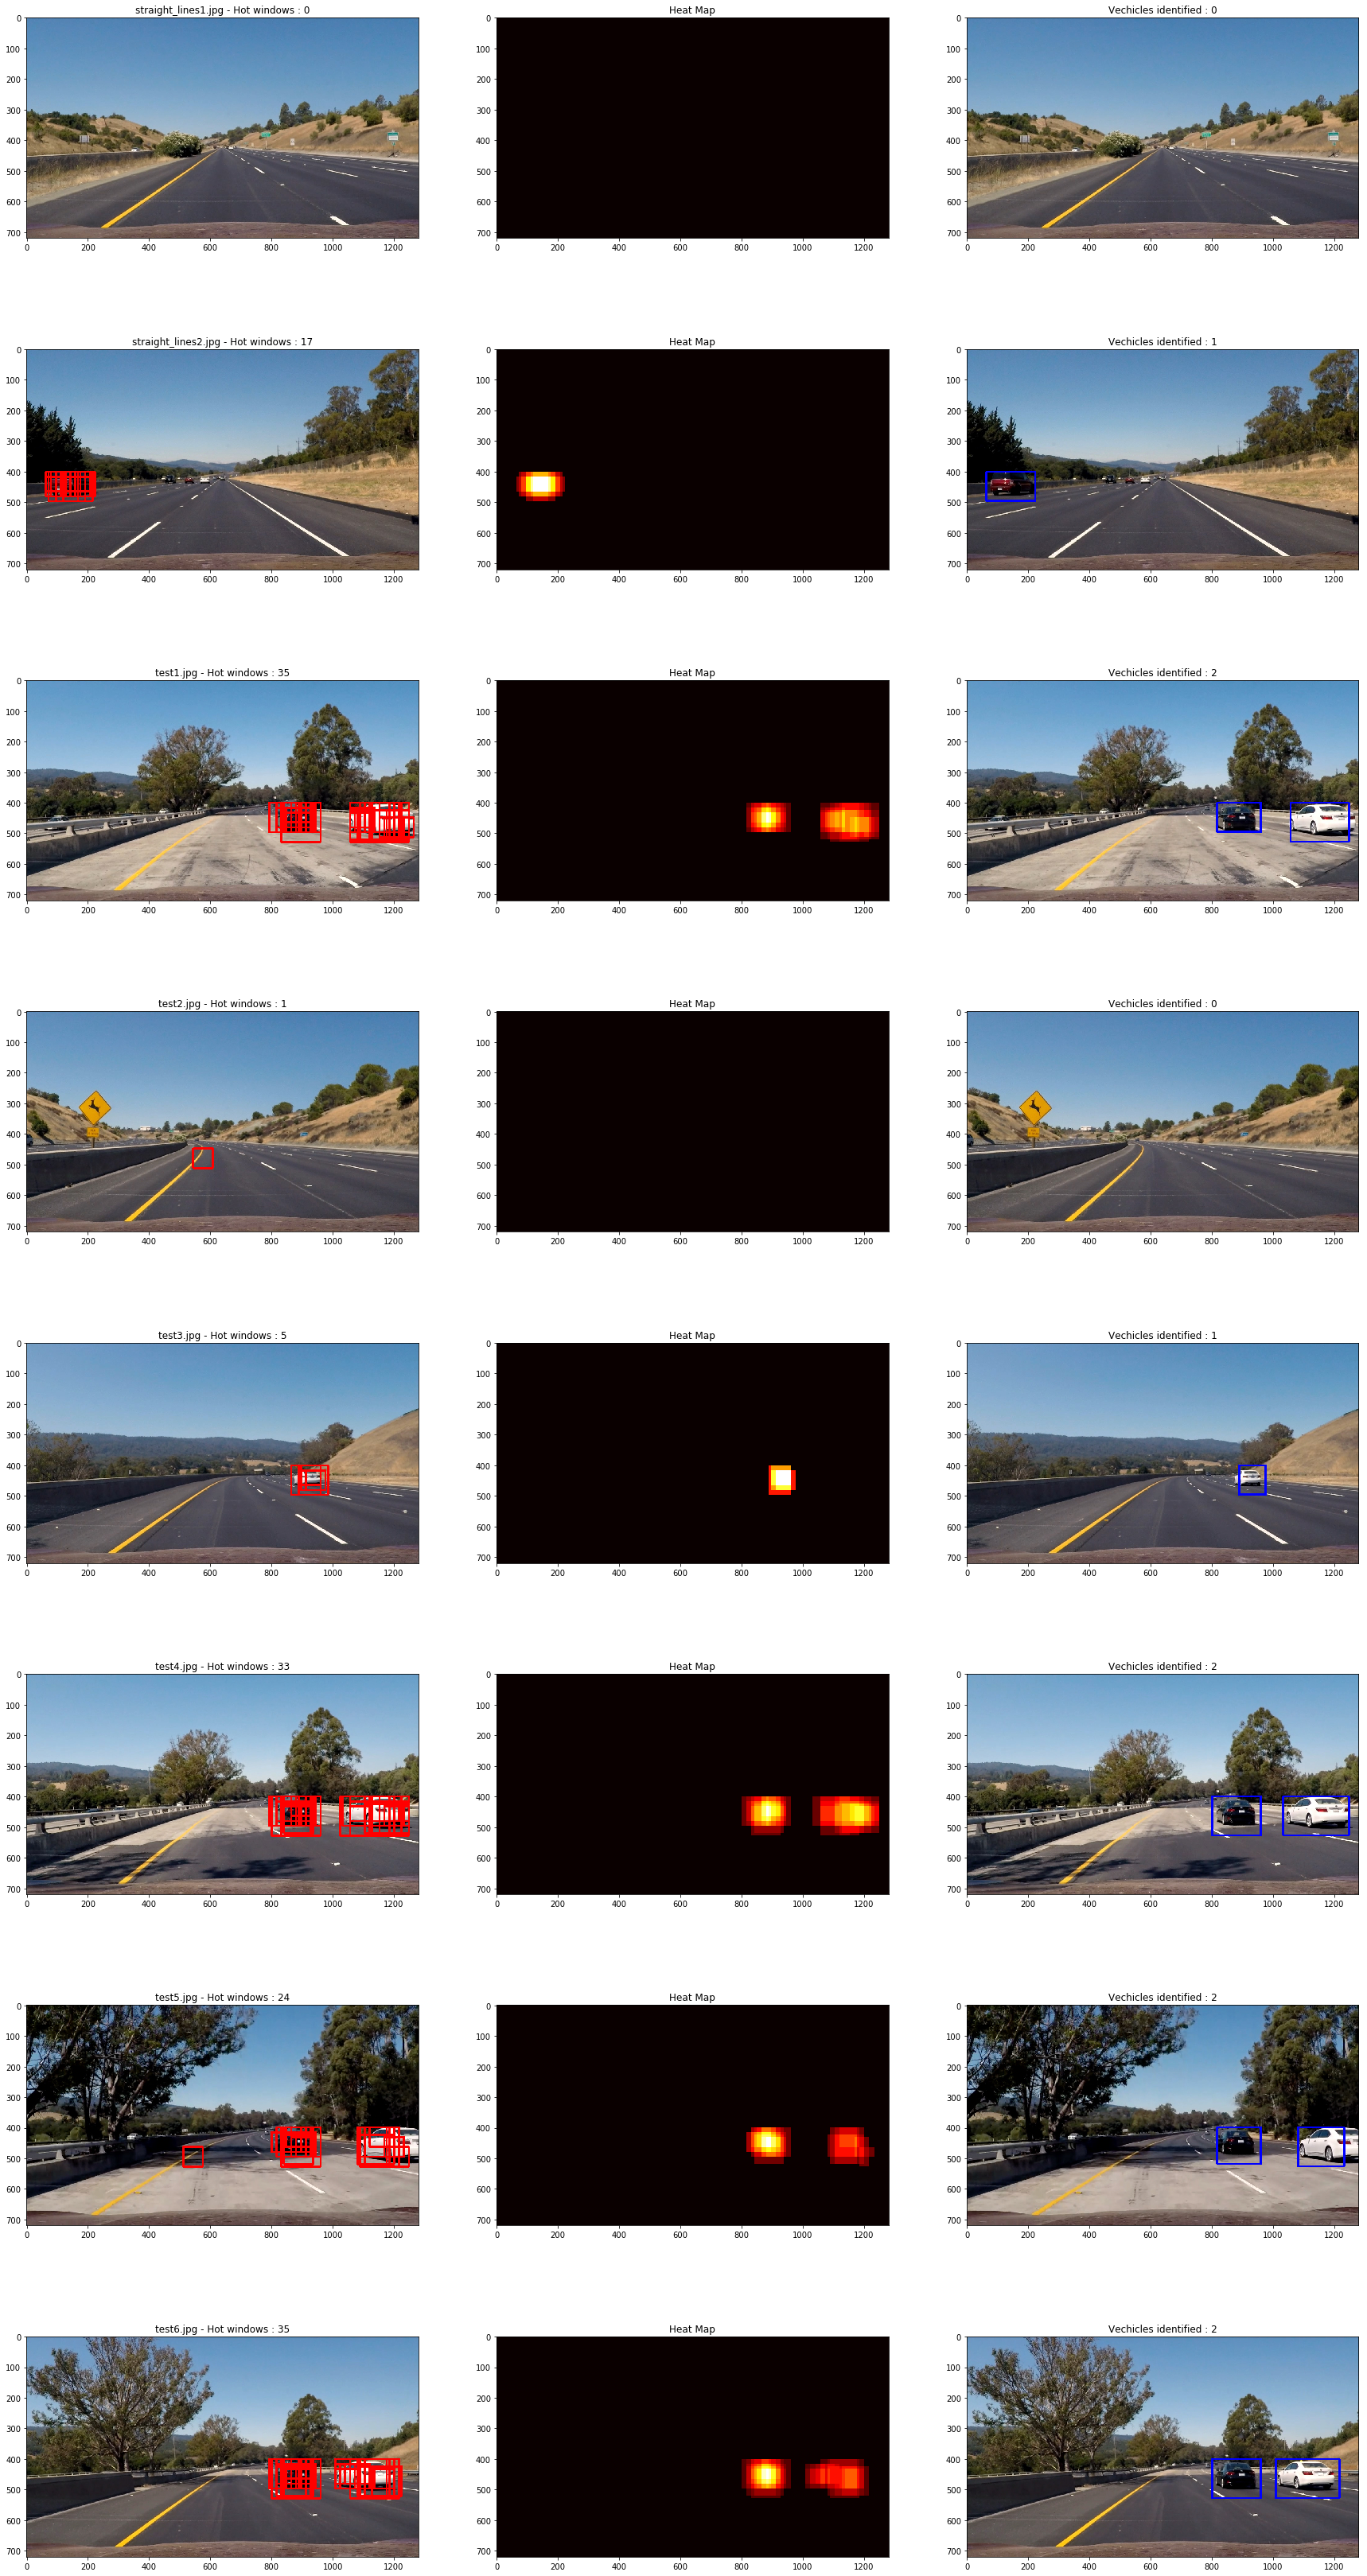

In [5]:
import os
import glob
test_images = glob.glob("./test_images/*.jpg")

cols = 3
rows = len(test_images)
fig, ax_arr = plt.subplots(rows, cols, figsize=(30,60))

for idx, image_file in enumerate(test_images):
    img = mpimg.imread(image_file)
    filename_base = os.path.basename(image_file)

    hot_windows = vehicle_detection.get_all_hot_windows(img)

    window_img = draw_boxes(img, hot_windows, color=(255, 0, 0), thick=6)
    mpimg.imsave("./output/{}_hotwindows.jpg".format(os.path.splitext(filename_base)[0]), window_img)
    
    heatmap = get_heatmap(img, hot_windows, heatmap_threshold=1)
    mpimg.imsave("./output/{}_heatmap.jpg".format(os.path.splitext(filename_base)[0]), heatmap)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    mpimg.imsave("./output/{}_final.jpg".format(os.path.splitext(filename_base)[0]), draw_img)

    plt.subplot(rows, cols, idx * cols + 1)
    plt.imshow(window_img)
    plt.title("{} - Hot windows : {}".format(os.path.basename(image_file), len(hot_windows)))
    plt.subplot(rows, cols, idx * cols + 2)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(rows, cols, idx * cols + 3)
    plt.imshow(draw_img)
    plt.title('Vechicles identified : {}'.format(labels[1]))

plt.show()

#### Project video

In [ ]:
from moviepy.editor import VideoFileClip

# project video vehicle detection
vehicle_detection = VehicleDetection(heatmap_history_n_items=4, heatmap_threshold=1, debug=True)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(vehicle_detection.pipeline)
white_clip.write_videofile("./output/project_video_out.mp4", audio=False)